<a href="https://colab.research.google.com/github/rinogrego/Learning-LLM/blob/main/research/Tutorial-Karpathy/backprop-and-micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Intro to Derivatives

In [ ]:
def f(x):
    return 3*x**2 - 4*x + 5

In [ ]:
f(3)

20

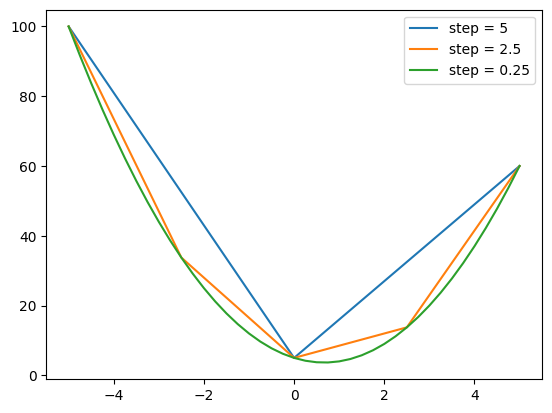

In [ ]:
step1 = 5
step2 = 2.5
step3 = 0.25
xs1 = np.arange(-5, 5.1, step1)
xs2 = np.arange(-5, 5.1, step2)
xs3 = np.arange(-5, 5.1, step3)
ys1 = f(xs1)
ys2 = f(xs2)
ys3 = f(xs3)
plt.plot(xs1, ys1, label=f"step = {step1}")
plt.plot(xs2, ys2, label=f"step = {step2}")
plt.plot(xs3, ys3, label=f"step = {step3}")
plt.legend()
plt.show()

In [ ]:
def f(x):
    return 3*x**2 - 4*x + 5

# derivative of f(x) is Dxf 6*x - 4
def Dxf(x):
    return 6*x - 4

x = 10.0
h = 0.5
approx = (f(x + h) - f(x)) / h
true = Dxf(x)
print(approx, true)

57.5 56.0


In [ ]:
# as the step size (h) goes to 0, the approximation value
# is approaching to the true value
x = 10.0
for h in [10.0, 5.0, 2.0, 1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.01, 0.001]:
    approx = (f(x + h) - f(x)) / h
    true = Dxf(x)
    print([approx, true])

[86.0, 56.0]
[71.0, 56.0]
[62.0, 56.0]
[59.0, 56.0]
[57.5, 56.0]
[56.75, 56.0]
[56.375, 56.0]
[56.1875, 56.0]
[56.09375, 56.0]
[56.0299999999927, 56.0]
[56.0029999999756, 56.0]


### Derivative of a function with multiple inputs (multivariable derivatives)

In [ ]:
def f(x):
    return 3*x**2 - 4*x + 5

In [ ]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1       :', d1)
print('d2       :', d2)
print('slope    :', (d2 - d1)/h)
# slope approx. equals to -3 because derivative of 'd1' w.r.t 'a' is -3

d1       : 4.0
d2       : 3.999699999999999
slope    : -3.000000000010772


In [ ]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1       :', d1)
print('d2       :', d2)
print('slope    :', (d2 - d1)/h)
# slope approx. equals to 2 because derivative of 'd1' w.r.t 'b' is 2

d1       : 4.0
d2       : 4.0002
slope    : 2.0000000000042206


### Building the data structure

In [ ]:
class Value:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

a = Value(3.0)
b = Value(2.0)
print(a + b)
# TypeError: unsupported operand type(s) for +: 'Value' and 'Value'
# -> add functionality

TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

In [ ]:
class Value:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data)
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out

In [ ]:
a = Value(3.0)
b = Value(-2.0)
print(a + b)
print(a * b)

Value(data=1.0)
Value(data=-6.0)


In [ ]:
# for more complex operations
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
d

Value(data=4.0)

In [ ]:
# we want to keep track of the operations done to calculate the variable
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(
            data = self.data + other.data,
            _children = (self, other),
            _op = '+'
        )
        return out

    def __mul__(self, other):
        out = Value(
            data = self.data * other.data,
            _children = (self, other),
            _op = '*'
        )
        return out

In [ ]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
print("d              :", d)
print("d's children   :", d._prev)
print("d's operation  :", d._op)
# the children is getting tracked

d              : Value(data=4.0)
d's children   : {Value(data=10.0), Value(data=-6.0)}
d's operation  : +


### Adding Visualization for the Computation

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(
            data = self.data + other.data,
            _children = (self, other),
            _op = '+'
        )
        return out

    def __mul__(self, other):
        out = Value(
            data = self.data * other.data,
            _children = (self, other),
            _op = '*'
        )
        return out

In [ ]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data, ), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b;    e.label = 'e'
d = e + c;  d.label = 'd'

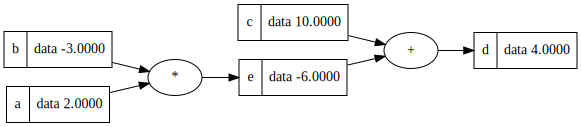

In [ ]:
draw_dot(d)

In [ ]:
# now approaching something we are familiar with...
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b;    e.label = 'e'
d = e + c;  d.label = 'd'
f = Value(-2.0, label='f')
L = d * f;  L.label = 'L'

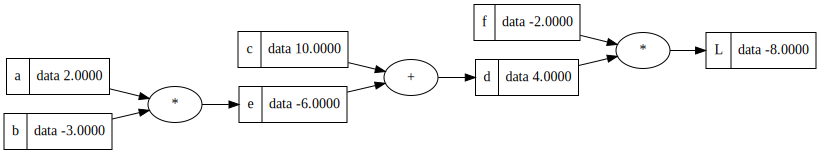

In [ ]:
draw_dot(L)

### The gradients

In [ ]:
# adding grad
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(
            data = self.data + other.data,
            _children = (self, other),
            _op = '+'
        )
        return out

    def __mul__(self, other):
        out = Value(
            data = self.data * other.data,
            _children = (self, other),
            _op = '*'
        )
        return out

In [ ]:
# adding grad

from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data: %.4f | grad: %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [ ]:
# now approaching something we are familiar with...
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b;    e.label = 'e'
d = e + c;  d.label = 'd'
f = Value(-2.0, label='f')
L = d * f;  L.label = 'L'

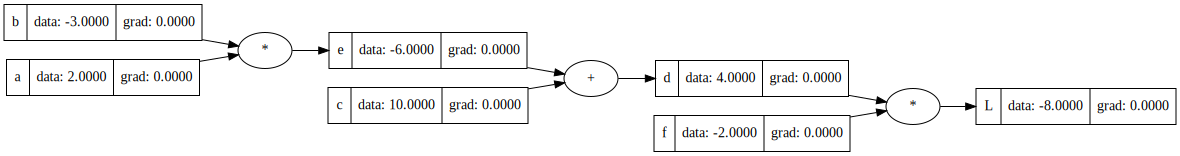

In [ ]:
draw_dot(L)

In [ ]:
# to demonstrate backprop
# derivates of L w.r.t. certain variable
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b;    e.label = 'e'
    d = e + c;  d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f;  L.label = 'L'
    L1 = L.data

    # w.r.t. variable 'a'
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b;    e.label = 'e'
    d = e + c;  d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f;  L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)

lol()
# 6.000000000021544

6.000000000021544


#### Explainer: tracking the gradient value from `L` to another variable

why 6?

the function is basically
```
L = d * f
L = (e + c) * f
L = ([a * b] + c) * f
```
unroll the equation
```
L = (a * b) * f + c * f
L = a * b * f + c * f
```
and derivative of `L` w.r.t. variable `a` is
```
DaL = b * f
```
as we know that
```
a = 2.0
b = -3.0
c = 10.0
f = -2.0
```
then
```
DaL = -3.0 * -2.0
DaL = 6
```
so, analytically, the derivative of `L` w.r.t. `a` is 6, hence the approximation value of the derivative should approach 6


In [ ]:
# try another variable
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b;    e.label = 'e'
    d = e + c;  d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f;  L.label = 'L'
    L1 = L.data

    # w.r.t. variable 'f'
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b;    e.label = 'e'
    d = e + c;  d.label = 'd'
    f = Value(-2.0 + h, label='f')
    L = d * f;  L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)

lol()
# 3.9999999999995595

3.9999999999995595


why 4?

again, with the same explanation
```
L = d * f
L = (e + c) * f
L = ([a * b] + c) * f
```
unroll the equation
```
L = (a * b) * f + c * f
L = a * b * f + c * f
```
and derivative of `L` w.r.t. variable `f` is
```
dL/df = a * b + c
```
as we know that
```
a = 2.0
b = -3.0
c = 10.0
f = -2.0
```
then
```
DaL = 2.0 * (-3.0) + 10.0
DaL = -6.0 + 10.0
DaL = 4.0
```
so, analytically, the derivative of `L` w.r.t. `f` is 4, hence the approximation value of the derivative should approach 4


#### Explainer: Chain Rule

for functions
```
e = a * b
d = e + c

L = d * f
L = (e + c) * f
L = ([a * b] + c) * f
```
the derivatives w.r.t. each variable
```
dL/df = d
dL/dd = f
dL/de = (dd/de) * (dL/dd) = 1 * f
dL/dc = (dd/dc) * (dL/dd) = 1 * f
dL/db = (de/db) * (dd/de) * (dL/dd) = a * 1 * f
dL/da = (de/da) * (dd/de) * (dL/dd) = b * 1 * f
```
input variables
```
a = 2.0
b = -3.0
c = 10.0
f = -2.0
```
calculate
```
e = a * b = -6.0
d = e + c = 4.0
L = d * f = -8.0
```
then
```
dL/dL = 1 (with itself)
dL/df = d = 4.0
dL/dd = f = -2.0
dL/de = (dd/de) * (dL/dd) = 1 * f = -2.0
dL/dc = (dd/dc) * (dL/dd) = 1 * f = -2.0
dL/db = (de/db) * (dd/de) * (dL/dd) = a * 1 * f = -4.0
dL/da = (de/da) * (dd/de) * (dL/dd) = b * 1 * f = 6.0
```

In [ ]:
a.grad = 6.0
b.grad = -4.0
c.grad = -2.0
d.grad = -2.0
e.grad = -2.0
f.grad = 4.0
L.grad = 1.0

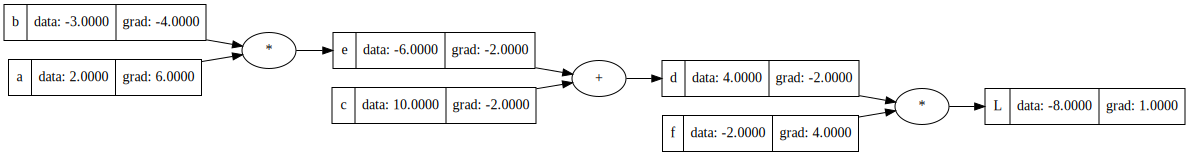

In [ ]:
draw_dot(L)

In [ ]:
# compare manual computation with code implementation for variable 'c'
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b;    e.label = 'e'
    d = e + c;  d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f;  L.label = 'L'
    L1 = L.data

    # w.r.t. variable 'c'
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0 + h, label='c')
    e = a*b;    e.label = 'e'
    d = e + c;  d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f;  L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)

lol()
# -1.9999999999953388
# dL/dc = -2

-1.9999999999953388


In [ ]:
# have u ever heard of learning rate?
lr = 0.001

a.grad = lr * 6.0
b.grad = lr * -4.0
c.grad = lr * -2.0
d.grad = lr * -2.0
e.grad = lr * -2.0
f.grad = lr * 4.0
L.grad = lr * 1.0

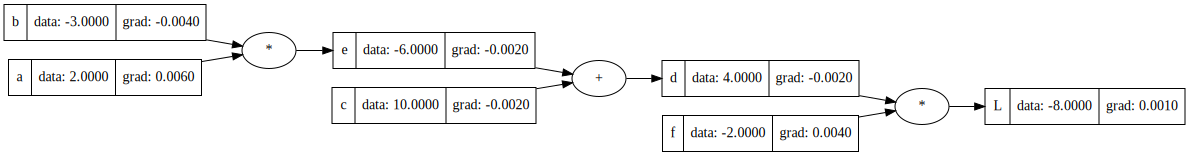

In [ ]:
draw_dot(L)

**NOTICE THE PATTERN**

- for '*' sign
  - f.grad = L.grad * d.data
  - d.grad = L.grad * f.data
  - a.grad = e.grad * b.data
  - b.grad = e.grad * a.data

- for '+' sign
  - e.grad = d.grad
  - c.grad = d.grad

***The gradients are FLOWING BACKWARDS***

In [ ]:
# updating the data

a.data += a.grad
b.data += b.grad
c.data += c.grad
d.data += d.grad
e.data += e.grad
f.data += f.grad
L.data += L.grad

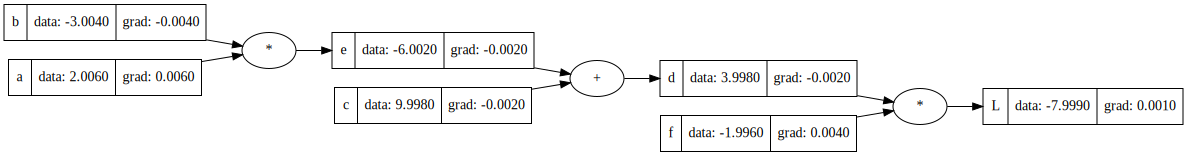

In [ ]:
draw_dot(L)

### Simulating Neuron

#### Activation function: `tanh`

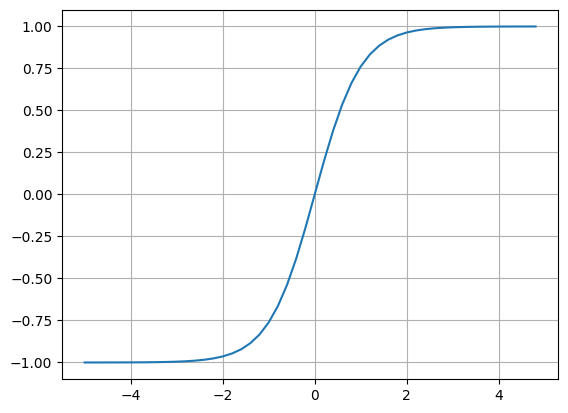

In [ ]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [ ]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b
b = Value(6.7, label='b')

# z = x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
z = x1w1x2w2 + b; z.label = 'z'

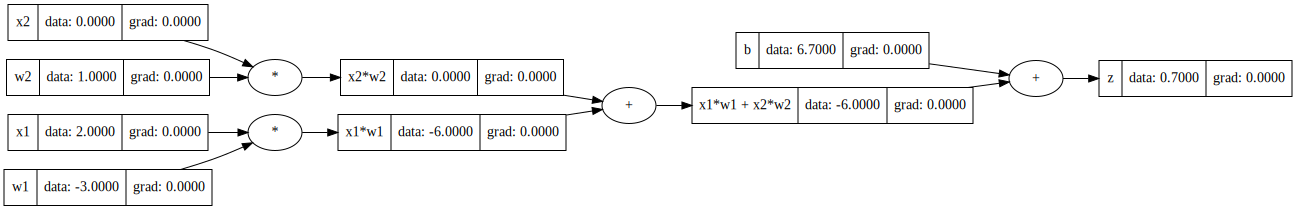

In [ ]:
draw_dot(z)

In [ ]:
# adding tanh
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(
            data = self.data + other.data,
            _children = (self, other),
            _op = '+'
        )
        return out

    def __mul__(self, other):
        out = Value(
            data = self.data * other.data,
            _children = (self, other),
            _op = '*'
        )
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(
            t,
            _children=(self, ),
            label='tanh'
        )
        return out

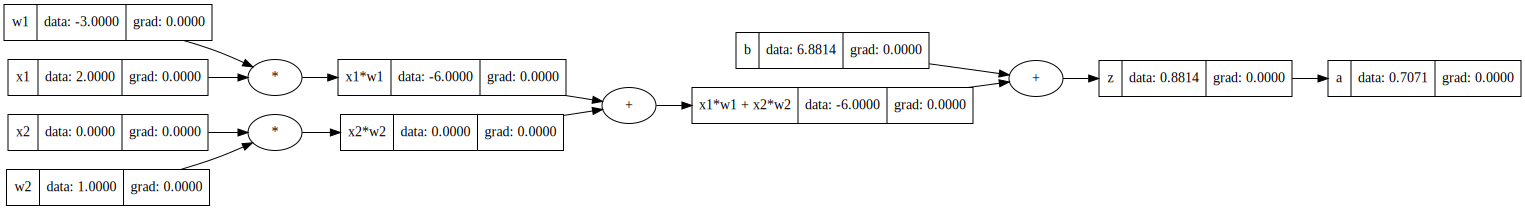

In [ ]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b
# weird value for proper computation
b = Value(6.8813735870195432, label='b')

# z = x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
z = x1w1x2w2 + b; z.label = 'z'
# tanh
a = z.tanh(); a.label = 'a'

draw_dot(a)

In [ ]:
# derivative of tanh is 1 - (tanh)^2
1 - a.data**2 # approx 0.5

0.4999999999999999

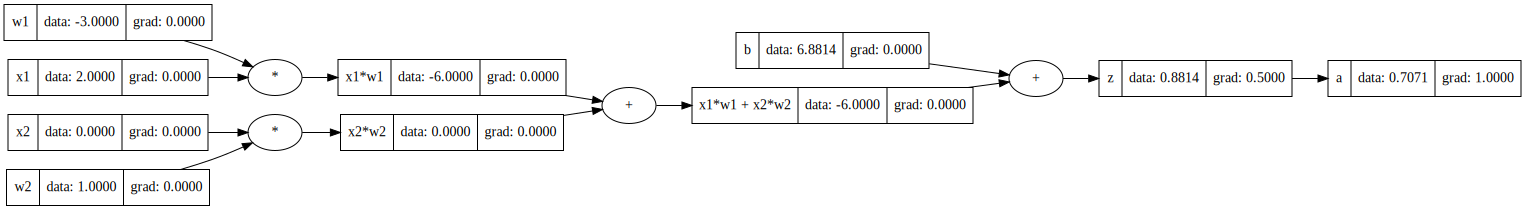

In [ ]:
# calculating the grads
a.grad = 1.0
z.grad = 0.5
draw_dot(a)

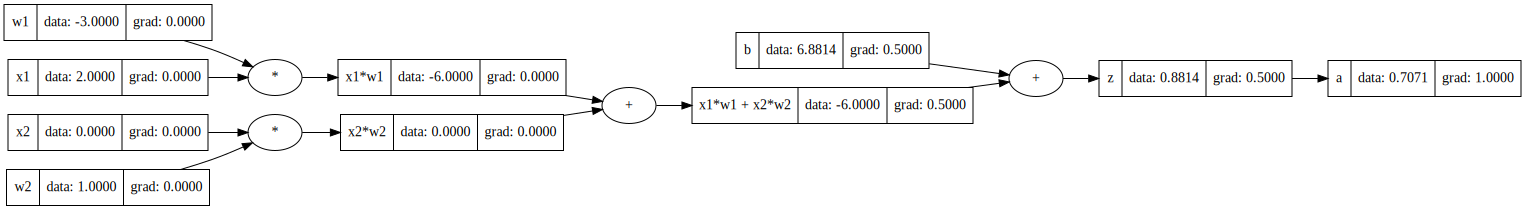

In [ ]:
# flow the gradients backward
x1w1x2w2.grad = 0.5
b.grad = 0.5
draw_dot(a)

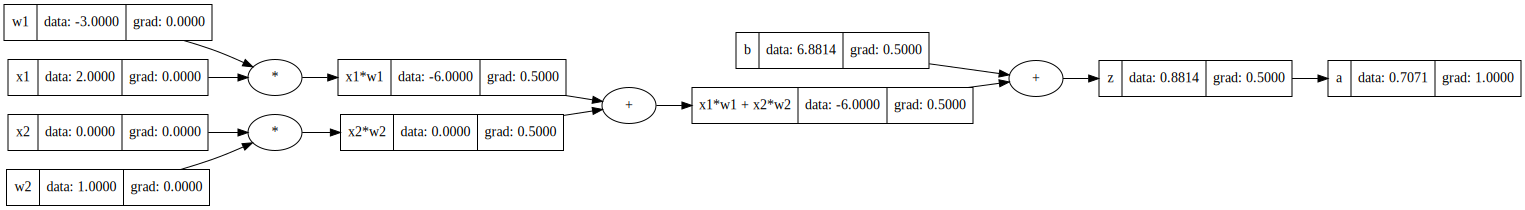

In [ ]:
# flow the gradients backward
x1w1.grad = 0.5
x2w2.grad = 0.5
draw_dot(a)

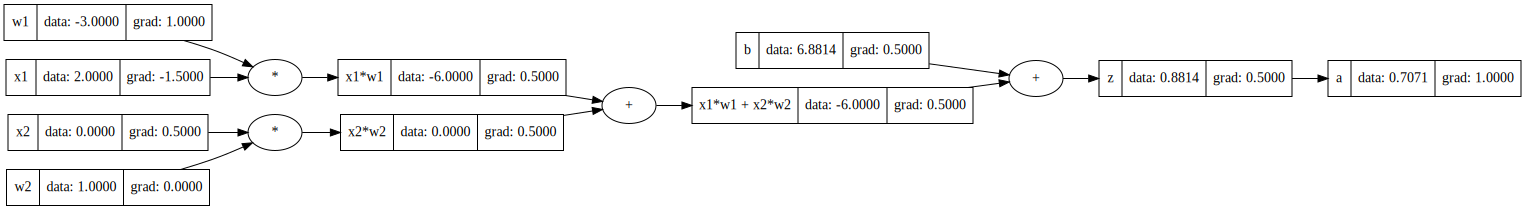

In [ ]:
# flow the gradients backward
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data
draw_dot(a)

### Let's automatically compute the grad now. We have enough manual computation

In [ ]:
# adding backprop feature
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(
            data = self.data + other.data,
            _children = (self, other),
            _op = '+'
        )

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(
            data = self.data * other.data,
            _children = (self, other),
            _op = '*'
        )

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(
            t,
            _children=(self, ),
            label='tanh'
        )

        def _backward():
            self.grad = (1.0 - t**2) * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

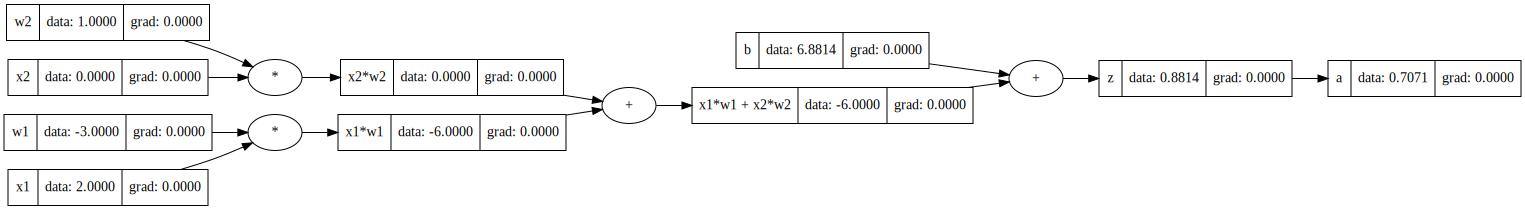

In [ ]:
# redefine the network

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b
# weird value for proper computation
b = Value(6.8813735870195432, label='b')

# z = x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
z = x1w1x2w2 + b; z.label = 'z'
# tanh
a = z.tanh(); a.label = 'a'

draw_dot(a)

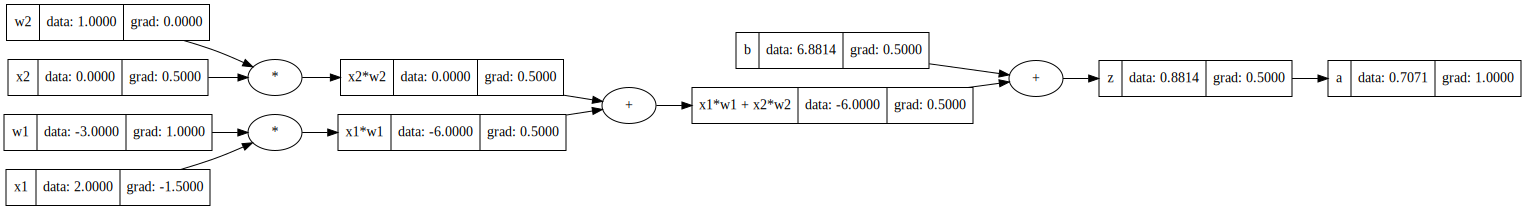

In [ ]:
a.grad = 1.0 # for base case, because if keep 0 then z._backward() will be zero
a._backward() # send 'grad a' backward to 'z'
z._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

# b._backward() is not needed because leaf nodes don't have any node to send the grad value backward to
b._backward()
# honestly, below are not needed, same reasoning with b term
x1._backward()
w1._backward()
x2._backward()
w2._backward()

# comment/uncomment and re-run the redefine code and backward code to see
draw_dot(a)

#### Implement topological sort

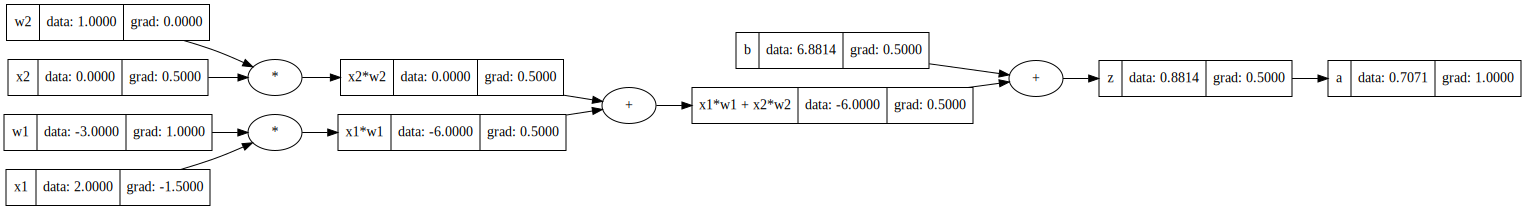

In [ ]:
# now creating the entire backprop flow
# using topological sort

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(a)

a.grad = 1.0
for node in reversed(topo):
    node._backward()

draw_dot(a)

In [ ]:
# now implement it inside the Value class
# adding backprop feature
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(
            data = self.data + other.data,
            _children = (self, other),
            _op = '+'
        )

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(
            data = self.data * other.data,
            _children = (self, other),
            _op = '*'
        )

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(
            t,
            _children=(self, ),
            label='tanh'
        )

        def _backward():
            self.grad = (1.0 - t**2) * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def backward(self):
        # build topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # only self.grad set to 1.0 because backward method
        # is usually called by the very back of the network
        # e.g. loss function
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

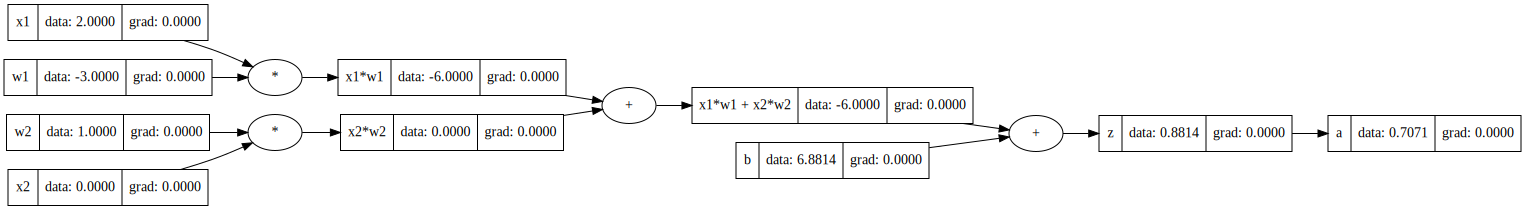

In [ ]:
# redefine the network

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b
# weird value for proper computation
b = Value(6.8813735870195432, label='b')

# z = x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
z = x1w1x2w2 + b; z.label = 'z'
# tanh
a = z.tanh(); a.label = 'a'

draw_dot(a)

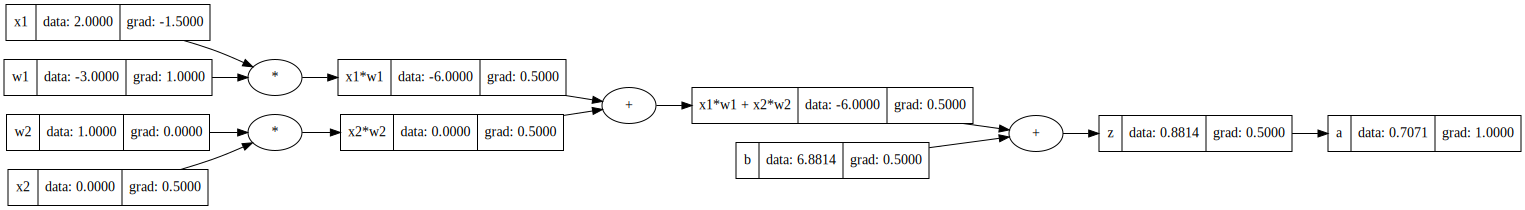

In [ ]:
# backprop
a.backward()

draw_dot(a)

### There IS a bug here...

tldr; if **a variable is used multiple times**, e.g.
```
a = Value(1.0, label='a')
b = Value(-2.0, label='b')
c = a + b
d = a + a
```
doing d.backward will cause problem for a.grad

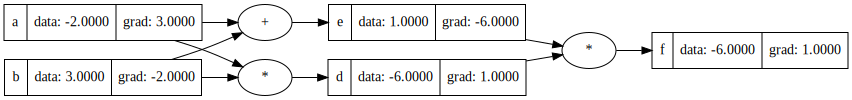

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'
f.backward()
draw_dot(f)

# the grad for a and b only account from
# a.grad = e.grad * b.data
# b.grad = e.grad * a.data
# the grad from d.grad is replaced, not accumulated

In [ ]:
# fix: the grads are accumulated during backward
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(data = self.data + other.data, _children = (self, other), _op = '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(data = self.data * other.data, _children = (self, other), _op = '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, _children=(self, ), label='tanh')

        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def backward(self):
        # build topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # only self.grad set to 1.0 because backward method
        # is usually called by the very back of the network
        # e.g. loss function
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [ ]:
e.grad * b.data + d.grad

-17.0

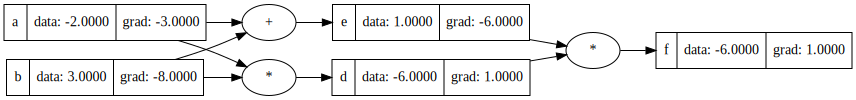

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'
f.backward()
draw_dot(f)

# the grad for a and b only account from
# a.grad = e.grad * b.data + d.grad
# b.grad = e.grad * a.data + d.grad

#### Explainer: How can a.grad and b.grad values are -3.0 and -8.0? Finding it Analytically...
```
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a*b
e = a+b
f = d*e

df/de = d = -6.0
df/dd = e = 1.0

df/da = d[d*e]/da
df/da = (dd/da * e) + (de/da * d) OR
  df/da = (dd/da)*(df/dd) + (de/da)*(df/de)
df/da = (b)*(e) + (1)*(d)
df/da = (3.0)*(1.0) + (1)*(-6.0)
df/da = -3.0

df/db = d[d*e]/db
df/db = (dd/db * e) + (de/db * d)
df/db = (a)*(e) + (1)*(d)
df/db = (-2.0)*(1.0) + (1)*(-6.0)
df/db = -8.0
```

Another way of doing it...
```
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a*b
e = a+b
f = d*e
```
means
```
f = (a * b) * (a + b)
f = (a**2 * b) + (a * b**2)
```
hence
```
df/da = 2*a*b + b**2
df/db = a**2 + 2*b*a
```
plug the values
```
a.grad = df/da = 2*(-2.0)*(3.0) + (3.0)**2 = -12.0 + 9.0 = -3.0
b.grad = df/db = (-2.0)**2 + 2*(3.0)*(-2.0) = 4.0 + -12.0 = -8.0
```

### Breaking `tanh` for exercise

#### Fixing some issues of addition and multiplication

In [ ]:
a = Value(2.0)
a + 1
# AttributeError: 'int' object has no attribute 'data'

AttributeError: 'int' object has no attribute 'data'

In [ ]:
# fix: enables 'int'/'float' for computation
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(data = self.data + other.data, _children = (self, other), _op = '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(data = self.data * other.data, _children = (self, other), _op = '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, _children=(self, ), label='tanh')

        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def backward(self):
        # build topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # only self.grad set to 1.0 because backward method
        # is usually called by the very back of the network
        # e.g. loss function
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [ ]:
a = Value(2.0)
a + 1, a * 2

(Value(data=3.0), Value(data=4.0))

In [ ]:
1 + a
# TypeError: unsupported operand type(s) for +: 'int' and 'Value'

TypeError: unsupported operand type(s) for +: 'int' and 'Value'

In [ ]:
# fix: addition / multiplication order
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(data = self.data + other.data, _children = (self, other), _op = '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(data = self.data * other.data, _children = (self, other), _op = '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, _children=(self, ), label='tanh')

        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def backward(self):
        # build topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # only self.grad set to 1.0 because backward method
        # is usually called by the very back of the network
        # e.g. loss function
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [ ]:
a = Value(2.0, label='a')
print(2 * a, a * 2)
print(3 + a, a + 3)

Value(data=4.0) Value(data=4.0)
Value(data=5.0) Value(data=5.0)


#### Introducing exp()

In [ ]:
# add exp() method
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(data = self.data + other.data, _children = (self, other), _op = '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(data = self.data * other.data, _children = (self, other), _op = '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, _children=(self, ), label='tanh')

        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), label='exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        # build topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # only self.grad set to 1.0 because backward method
        # is usually called by the very back of the network
        # e.g. loss function
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [ ]:
a = Value(3.0)
a.exp()

Value(data=20.085536923187668)

#### Introducing division '/' and other expressions

In [ ]:
a = Value(2.0, label='a')
b = Value(4.0, label='b')
a / b
# TypeError: unsupported operand type(s) for /: 'Value' and 'Value'

TypeError: unsupported operand type(s) for /: 'Value' and 'Value'

In [ ]:
# a/b = a*(1/b) = a*(b**-1)
a * (b**-1)
# TypeError: unsupported operand type(s) for ** or pow(): 'Value' and 'int'

TypeError: unsupported operand type(s) for ** or pow(): 'Value' and 'int'

In [ ]:
display(a * b)
display(b * a)

Value(data=8.0)

Value(data=8.0)

In [ ]:
# add division, subtraction, negation,
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(data = self.data + other.data, _children = (self, other), _op = '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(data = self.data * other.data, _children = (self, other), _op = '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, _children=(self, ), _op='tanh')

        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        # build topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # only self.grad set to 1.0 because backward method
        # is usually called by the very back of the network
        # e.g. loss function
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [ ]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

#### Reimplement `tanh`

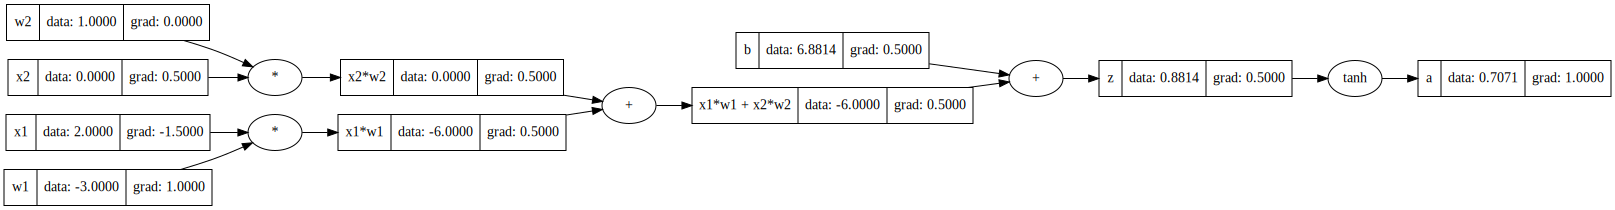

In [ ]:
# redefine the network

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b
# weird value for proper computation
b = Value(6.8813735870195432, label='b')

# z = x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
z = x1w1x2w2 + b; z.label = 'z'
# tanh
a = z.tanh(); a.label = 'a'

a.backward()
draw_dot(a)

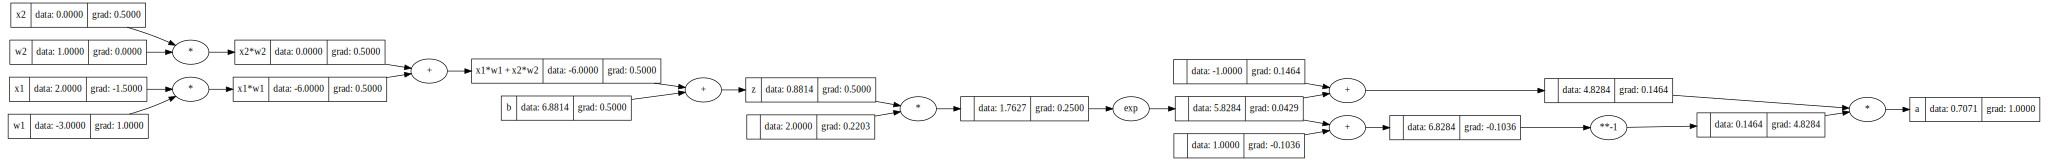

In [ ]:
# redefine the network

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b
# weird value for proper computation
b = Value(6.8813735870195432, label='b')

# z = x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
z = x1w1x2w2 + b; z.label = 'z'

# tanh
# a = z.tanh(); a.label = 'a'
e = (2*z).exp()
a = (e - 1) / (e + 1)
a.label = 'a'

a.backward()
draw_dot(a)

### Personal Exercise: implement f(x) = k**x

#### Explainer: Derivatives of each expression

Exponential
```
y = e**x = exp(x)
dy/dx = e**x = exp(x)
```
Power Rule
```
# k constant
y = x**k
dy/dx = k * x**(k-1)
```
Exponential (General form)
```
# k constant
y = k**x
y = exp(x*ln(k))
# use substitution method. assume
u = x*ln(k)
# then
du/dx = ln(k)
# we can rewrite into the following
y = exp(u)
# and
dy/dx = (dy/du) * (du/dx)
# hence we obtain
dy/dx = exp(u) * ln(k)
# resubstitute
dy/dx = exp(x*ln(k)) * ln(k)
dy/dx = k**x * ln(k)
```

#### Implement `__rpow__`

In [ ]:
a = Value(3.0, label='a')
b = Value(2.0, label='b')
d = a.exp()     ; d.label='d'
c = 2 ** b      ; c.label='c'
e = c * d       ; e.label='e'
f = a + e       ; f.label='f'

TypeError: unsupported operand type(s) for ** or pow(): 'int' and 'Value'

In [ ]:
# implement __rpow__
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(data = self.data + other.data, _children = (self, other), _op = '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(data = self.data * other.data, _children = (self, other), _op = '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rpow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(other**self.data, (self, ), f'{other}**')

        def _backward():
            self.grad += other**self.data * math.log(other) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, _children=(self, ), _op='tanh')

        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        # keep track of the grad flow
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        # build topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # only self.grad set to 1.0 because backward method
        # is usually called by the very back of the network
        # e.g. loss function
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [ ]:
b = Value(2.0)
print((-3.0) ** b)
print(-3.0 ** b)

Value(data=9.0)
Value(data=-9.0)


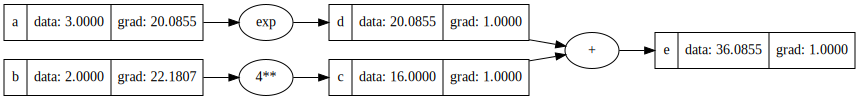

In [ ]:
a = Value(3.0, label='a')
b = Value(2.0, label='b')
d = a.exp();    d.label='d'
c = 4 ** b;     c.label='c'
e = c + d;      e.label='e'

e.backward()
draw_dot(e)

In [ ]:
# a.grad = 20.0855
# b.grad = 22.1807

Now to make sure... from
```
a = Value(3.0, label='a')
b = Value(2.0, label='b')

d = a.exp();    d.label='d'
c = 4 ** b;     c.label='c'
e = c + d
```
we obtain
```
e = 4**b + e**a
e = 4**2.0 + e**3.0
e = 16 + 20.0855369
e = 36.0855369
```
and its derivative w.r.t. variable 'a' and 'b'
```
de/da = e**a            = 20.0855369
de/db = 4**b * ln(4)    = 16 * ln(4) = 16 * 1.38629436 = 22.1807098
```
which is correct with our implementation

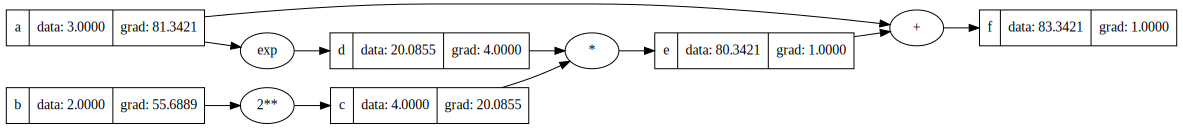

In [ ]:
a = Value(3.0, label='a')
b = Value(2.0, label='b')
d = a.exp()     ; d.label='d'
c = 2 ** b      ; c.label='c'
e = c * d       ; e.label='e'
f = a + e       ; f.label='f'

f.backward()
draw_dot(f)

### Comparison with PyTorch

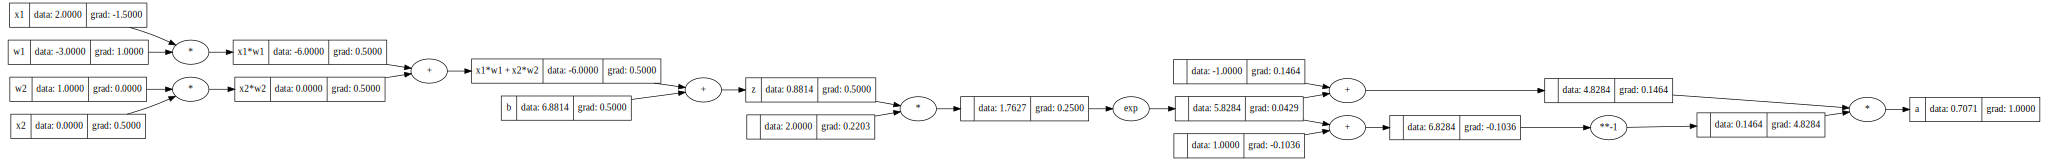

In [ ]:
# redefine the network

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b
# weird value for proper computation
b = Value(6.8813735870195432, label='b')

# z = x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
z = x1w1x2w2 + b; z.label = 'z'

# tanh
# a = z.tanh(); a.label = 'a'
e = (2*z).exp()
a = (e - 1) / (e + 1)
a.label = 'a'

a.backward()
draw_dot(a)

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double();               x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();               x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();              w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();               w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


### Building Multilayer Perceptron

In [ ]:
import random

In [ ]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, X):
        act = sum([xi*wi for xi, wi in zip(X, self.w)], self.b)
        out = act.tanh()
        return out

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, X):
        outs = [neuron(X) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, X):
        for layer in self.layers:
            X = layer(X)
        return X

In [ ]:
X = [2.0, 3.0, -1.0]
n = Neuron(3)
n(X)

Value(data=-0.892399718786538)

In [ ]:
X = [2.0, 3.0, -1.0]
nl = Layer(3, 4)
nl(X)

[Value(data=0.9019126245001977),
 Value(data=-0.9983509914336927),
 Value(data=0.8831494533105312),
 Value(data=0.46131458043397017)]

In [ ]:
X = [2.0, 3.0, -1.0]
nn = MLP(nin=3, nouts=[2, 3, 2, 1])
nn(X)

Value(data=0.13312583633122924)

In [ ]:
# draw_dot(nn(X))

In [ ]:
# sample dataset
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypreds = [nn(x) for x in xs]
ypreds

[Value(data=0.13312583633122924),
 Value(data=0.30930056474911666),
 Value(data=0.16463451598644824),
 Value(data=0.22843268112651754)]

In [ ]:
loss = sum([(y_pred - y_true)**2 for y_true, y_pred in zip(ys, ypreds)])
loss

Value(data=4.41742846786939)

In [ ]:
loss.backward()

In [ ]:
print(nn.layers[0].neurons[1].w[0])
print(nn.layers[0].neurons[1].w[0].grad)

Value(data=-0.30637358255024894)
0.1649009101630156


In [ ]:
# draw_dot(loss)

In [ ]:
# adding parameters
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, X):
        act = sum([xi*wi for xi, wi in zip(X, self.w)], self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, X):
        outs = [neuron(X) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self,):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, X):
        for layer in self.layers:
            X = layer(X)
        return X

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
X = [2.0, 3.0, -1.0]
nn = MLP(nin=3, nouts=[2, 3, 2, 1])
nn(X)

Value(data=0.7054712260388041)

In [ ]:
nn.parameters()

[Value(data=-0.5205577372133252),
 Value(data=0.720387609472976),
 Value(data=0.4134374382039967),
 Value(data=-0.8048341108371178),
 Value(data=-0.41831010901604815),
 Value(data=-0.030041235221050178),
 Value(data=-0.06272949734354283),
 Value(data=0.45772359684941466),
 Value(data=-0.1943840962423793),
 Value(data=-0.249074157624126),
 Value(data=0.25401077999193356),
 Value(data=0.1222543840411352),
 Value(data=-0.16343706027496574),
 Value(data=-0.875446669729006),
 Value(data=-0.9917973964810891),
 Value(data=0.48516904660609383),
 Value(data=0.38613309290622433),
 Value(data=-0.09464653980381454),
 Value(data=-0.9141363218284313),
 Value(data=0.9740859936661854),
 Value(data=0.41668893084218106),
 Value(data=0.1355073319475375),
 Value(data=-0.7315109988712618),
 Value(data=0.9874593409883423),
 Value(data=-0.7814495339087411),
 Value(data=0.29980305788689354),
 Value(data=0.07729654857996304),
 Value(data=0.617515835517854)]

### Gradient Descent

In [ ]:
# sample dataset
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
nn = MLP(3, [2, 2, 1])

In [ ]:
for k in range(101):

    # forward pass
    ypred = [nn(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in nn.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in nn.parameters():
        p.data += -0.1 * p.grad

    if k%10==0:
        print(k, loss.data)

0 4.807766973081503
10 0.07206595433381685
20 0.03496031248312337
30 0.022956150150979182
40 0.017040100243979575
50 0.013526602128703063
60 0.011202958037881608
70 0.009554087150628289
80 0.008324282905685373
90 0.007372338159814142
100 0.006613969555556872
